# MNIST Handwritten Digit classification using CNN

In [2]:
# Imports

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from keras.datasets import mnist
from sklearn.model_selection import KFold
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as ps

## Data analysis

We have `60000` samples in the train set and `10000` in the test set.
A `MNIST` image is grayscale and has a dimension of `28x28`.

The output represents a digit.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'train input shape: {x_train.shape}')
print(f'train output shape: {y_train.shape}')
print(f'test input shape: {x_test.shape}')
print(f'test output shape: {y_test.shape}')

rows = 2
cols = 10
imagesPerRow = cols // rows
fig = ps.make_subplots(rows, cols)
for idx, img in enumerate(x_train[:cols]):
    fig.add_trace(px.imshow(img, binary_string=True).data[0], row=int(idx / imagesPerRow) + 1, col=idx % imagesPerRow + 1)

fig.show()

train input shape: (60000, 28, 28)
train output shape: (60000,)
test input shape: (10000, 28, 28)
test output shape: (10000,)


## Preparing data for training

We know that the pixel values of an image are unsigned integers in the range `0-255`. We can normalize these values and bring them in the `(0, 1)` interval.

Moreover, we are going to use Cross Validation later, so we can combine the training and test data.

In [44]:
# X = np.append(x_train, x_test, axis=0)
X = x_train
X = X.astype('float32')
X = keras.utils.normalize(X, axis=0)
print(f'input shape: {X.shape}')

# y = np.append(y_train, y_test, axis=0)
y = y_train
y = y.astype('float32')
print(f'output shape: {y.shape}')

print(X[0][12:14])
print(y[:5])

fig = px.imshow(X[0], binary_string=True)
fig.show()

input shape: (60000, 28, 28)
output shape: (60000,)
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 3.1754366e-04 5.9204116e-03 7.9408512e-03 2.0288168e-03
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.0405582e-03 6.7539513e-03 5.7685641e-03
  3.9159502e-03 2.5919334e-03 2.4138864e-05 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[5. 0. 4. 1. 9.]


## Model definition

### Model

We are going to use a `Sequential` model which is a linear stack of layers.

### Layers

The layer used ar the following:
1. `Conv2D`

The Conv2D layer creates a convolution kernel on the given input.

2. `MaxPooling2D`

This layer is usually used to down-sample the input. It uses a sliding window approach and takes the maximum value from
the given area within the full input.

3. `Flatten`

This layer is used to flatten the 2D input array to an 1D array. In our case, it is going to transform a `28x28` image to
an array of `784` pixels.

4. `Dense`

This layer is a fully connected. It maps each input with the given number of neurons.

### Optimizer

Adam (Adaptive Moment Estimation)

**

### Loss function

**Sparse Categorical Cross-Entropy**

*no need for one hot encoding*

*the output layer must be configured with `n` nodes (one for each class)*

*softmax activation can be used in the output layer*

In [45]:
def build_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation=tf.nn.relu, kernel_initializer=keras.initializers.he_uniform, input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPool2D(input_shape=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation=tf.nn.relu))
    model.add(keras.layers.Dense(10, activation=tf.nn.softmax))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

## Evaluate model

In [46]:
EPOCHS = 3
NO_FOLDS = 7
scores = []
histories = []
kf = KFold(NO_FOLDS, shuffle=True, random_state=1)
for train_idx, test_idx in kf.split(X):

    # train
    trainX = X[train_idx]
    trainY = y[train_idx]

    # test data
    testX = X[test_idx]
    testY = y[test_idx]

    model = build_model()
    history = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=32, validation_data=(testX, testY), verbose=0)

    _, acc = model.evaluate(testX, testY, verbose=0)
    print(f'acc: {acc}')

    histories.append(history)
    scores.append(acc)


acc: 0.9555529356002808
acc: 0.9527531266212463
acc: 0.9643023610115051
acc: 0.9618480801582336
acc: 0.9627814888954163
acc: 0.9565978050231934
acc: 0.962664783000946


## Present results

Accuracy: mean=0.959500082901546, std=0.004121070005435329


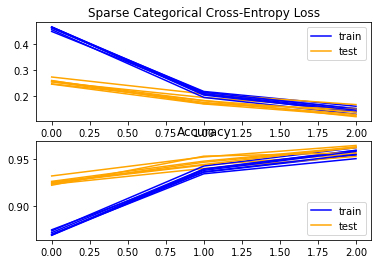

In [47]:
print(f'Accuracy: mean={np.mean(scores)}, std={np.std(scores)}')
fig = px.box(pd.DataFrame(data=scores, columns=['Accuracy']), y='Accuracy')
fig.show()

import matplotlib.pyplot as plt
for idx, history in enumerate(histories):
    h = history.history
    plt.subplot(2, 1, 1)
    plt.title('Sparse Categorical Cross-Entropy Loss')
    plt.plot(h['loss'], color='blue', label='train')
    plt.plot(h['val_loss'], color='orange', label='test')
    if idx == 0:
        plt.legend(loc='upper right')

    plt.subplot(2, 1, 2)
    plt.title('Accuracy')
    plt.plot(h['accuracy'], color='blue', label='train')
    plt.plot(h['val_accuracy'], color='orange', label='test')
    if idx == 0:
        plt.legend(loc='lower right')

plt.show()